In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

import glob
import math
import json
import os
import wandb
from datasets import get_real_dataset
from utils import hash_dict, signal_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import collections
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import FormatStrFormatter

color_pallete = "colorblind"
cb = list(sns.color_palette(color_pallete))
color_pallete = "rocket"
rocket = list(sns.color_palette(color_pallete))

color_pallete = [cb[0], cb[-4], rocket[3], rocket[2], rocket[0]]

sns.set_palette(color_pallete)

markers = ['o', 'x', '*', '^', 'D', 'p', '8', 's', 'p', 'D', 'V']

In [2]:
def get_model_dir(config, experiment_name):
    data_directory = os.environ.get("EXPERIMENT_DATA") if "EXPERIMENT_DATA" in os.environ else os.getcwd()

    keys_to_ignore = ["dataset_size_coef", "val_size", "num_epochs"]
    config_to_hash = {k:v for k, v in config.items() if k not in keys_to_ignore}
    if "early_stopping" in config_to_hash:
        config_to_hash["early_stopping"] = 5

    config_hash = hash_dict(config_to_hash)
    model_dir = f"{data_directory}/checkpoints/{experiment_name}/{config_hash}/"

    return model_dir

In [20]:
project_path = "whfourier/SyntheticLargeEarly10"
experiment_name = "synthetic"

criteria = {
    "n": 50,
    "fix_seed": [1, 2, 3],
    "sample_seed": [11, 22, 33, 44, 55],
    "random_seed": [11, 22, 33, 44, 55],
    "dataset_size_coef": [1, 2, 3, 4, 5, 6, 7, 8],
    "training_method": ["normal", "EN-S", "hashing"],
    # "training_method": [ "Lasso", "Random Forest", "XGBoost", "normal", "EN-S", "hashing"]
    "early_stopping": 10
}
file = f"files/synthetic_large_{criteria['n']}_2.json"

In [22]:
api = wandb.Api(timeout=60)

seeded_best_results = {}
seeded_runtimes = {}
seeded_best_of_epoch_results = {}
seeded_best_of_epoch_runtimes = {}
for fix_seed in criteria["fix_seed"]:
    best_results = {} # train_size.training_method
    runtimes = {} # train_size.training_method
    best_of_epoch_results = {} # train_size.training_method
    best_of_epoch_runtimes = {} # train_size.training_method
    for train_size in criteria["dataset_size_coef"]:
        best_results_train_size = {}
        runtimes_train_size = {}
        best_of_epoch_results_train_size = {}
        best_of_epoch_runtimes_train_size = {}
        for training_method in criteria["training_method"]:
            filters = {f'config.{k}': v for k, v in criteria.items()}
            filters["config.training_method"] = training_method
            filters["config.dataset_size_coef"] = train_size
            filters["config.fix_seed"] = fix_seed
            filters.pop("config.random_seed", None)
            filters.pop("config.sample_seed", None)
            
            if training_method == "alternate (SPRIGHT)":
                filters["config.training_method"] = "alternate"
                filters["config.fourier_method"] = {"$ne": "swht"}
            elif training_method == "alternate (swht)":
                filters["config.training_method"] = "alternate"
                filters["config.fourier_method"] = "swht"
            
            full_runs = api.runs(project_path, filters=filters)
            
            if training_method == "hashing":
                bs = sorted(set([run.config["b"] for run in full_runs]))
                run_set = {f"hashing (b={b})":[run for run in full_runs if run.config["b"]==b] for b in bs}
            else:
                run_set = {training_method: full_runs}
            
            for training_method, runs in run_set.items():
                print(train_size, training_method, len(runs))

                best_results_training_method = []
                runtimes_training_method = []
                best_of_epoch_results_training_method = []
                best_of_epoch_runtimes_training_method = []

                for sample_seed in criteria["sample_seed"]:
                    for random_seed in criteria["random_seed"]:
                        # selected_runs = [run for run in runs
                        #                 if (run.config["sample_seed"]==sample_seed) and (run.config["random_seed"]==random_seed)]
                        selected_configs = [run.config for run in runs
                                        if (run.config["sample_seed"]==sample_seed) and (run.config["random_seed"]==random_seed)]
                        # histories = [run.history(pandas=False)[:-criteria["early_stopping"]] for run in selected_runs]

                        histories = []
                        for train_config in selected_configs:
                            train_config["train_size"] = train_config["n"] * train_config["k"] * train_config["dataset_size_coef"]
                            model_dir = get_model_dir(train_config, experiment_name)
                            try:
                                log_file = glob.glob(f'{model_dir}/log*.json')[0]
                                # Load Final logs
                                with open(log_file) as log:
                                    histories.append(json.load(log))
                            except:
                                raise Exception(f"{model_dir}'s log not found.\n{train_config}")

                        max_epoch = max([len(h) for h in histories])
                        # Wrap all histories to max epoch
                        for history in histories:
                            if len(history) < max_epoch:
                                history.extend([history[-1]]*(max_epoch - len(history)))
                        
                        best_of_epoch_test_r2 = []
                        best_of_epoch_runtime = []
                        for epoch in range(max_epoch):
                            best_model_idx = np.argmax([h[epoch].get("max_val_r2", -math.inf) for h in histories])
                            best_of_epoch_test_r2.append(histories[best_model_idx][epoch]["best_test_r2"])
                            # best_of_epoch_runtime.append(sum([h["train_time"] for h in histories[best_model_idx][:epoch+1]]))
                            if epoch == 0: # Not averaging the first slow epoch
                                best_of_epoch_runtime.append(histories[best_model_idx][0]["train_time"])
                            else:    
                                average_time = sum([h["train_time"] for h in histories[best_model_idx][1:]]) / (len(histories[best_model_idx])-1)
                                best_of_epoch_runtime.append(average_time * epoch + histories[best_model_idx][0]["train_time"])

                        # best_model_idx = np.argmax([h[-1].get("max_val_r2", -math.inf) for h in histories])
                        # best_of_epoch_test_r2 = [e["best_test_r2"] for e in histories[best_model_idx]]
                        # best_of_epoch_runtime = list(np.cumsum([e["train_time"] for e in histories[best_model_idx]]))
                        
                        best_results_training_method.append(best_of_epoch_test_r2[-1])
                        runtimes_training_method.append(best_of_epoch_runtime[-1])
                        best_of_epoch_results_training_method.append(best_of_epoch_test_r2)
                        best_of_epoch_runtimes_training_method.append(best_of_epoch_runtime)

                        # best_model_idx = np.argmax([run.summary.get("max_val_r2", -math.inf) if run.config["sample_seed"]==sample_seed and run.config["random_seed"]==random_seed else -math.inf 
                        #                             for run in runs])
                        # best_results_training_method.append(runs[best_model_idx].summary.get("best_test_r2", -math.inf))
                        # if "train_time" in runs[best_model_idx].summary:
                        #     runtimes_training_method.append(np.sum(runs[best_model_idx].history()["train_time"][:-criteria["early_stopping"]]))
                        # else:
                        #     runtimes_training_method.append(runs[best_model_idx].summary.get("_runtime", -math.inf))
                    
                best_results_train_size[training_method] = best_results_training_method
                runtimes_train_size[training_method] = runtimes_training_method
                best_of_epoch_results_train_size[training_method] = best_of_epoch_results_training_method
                best_of_epoch_runtimes_train_size[training_method] = best_of_epoch_runtimes_training_method
        best_results[train_size] = best_results_train_size
        runtimes[train_size] = runtimes_train_size
        best_of_epoch_results[train_size] = best_of_epoch_results_train_size
        best_of_epoch_runtimes[train_size] = best_of_epoch_runtimes_train_size
    seeded_best_results[fix_seed] = best_results
    seeded_runtimes[fix_seed] = runtimes
    seeded_best_of_epoch_results[fix_seed] = best_of_epoch_results
    seeded_best_of_epoch_runtimes[fix_seed] = best_of_epoch_runtimes

# Save
data_to_dump = {
    "seeded_best_results": seeded_best_results,
    "seeded_runtimes": seeded_runtimes,
    "seeded_best_of_epoch_results": seeded_best_of_epoch_results,
    "seeded_best_of_epoch_runtimes": seeded_best_of_epoch_runtimes,
}
with open(file, "w") as outfile:
    json.dump(data_to_dump, outfile)

1 normal 25
1 EN-S 25
1 hashing (b=7) 75
1 hashing (b=10) 75
1 hashing (b=13) 75
2 normal 25
2 EN-S 25
2 hashing (b=7) 75
2 hashing (b=10) 75
2 hashing (b=13) 75
3 normal 25
3 EN-S 25
3 hashing (b=7) 75
3 hashing (b=10) 75
3 hashing (b=13) 75
4 normal 25
4 EN-S 25
4 hashing (b=7) 75
4 hashing (b=10) 75
4 hashing (b=13) 75
5 normal 25
5 EN-S 25
5 hashing (b=7) 75
5 hashing (b=10) 75
5 hashing (b=13) 75
6 normal 25
6 EN-S 25
6 hashing (b=7) 75
6 hashing (b=10) 75
6 hashing (b=13) 75
7 normal 25
7 EN-S 25
7 hashing (b=7) 75
7 hashing (b=10) 75
7 hashing (b=13) 75
8 normal 25
8 EN-S 25
8 hashing (b=7) 75
8 hashing (b=10) 75
8 hashing (b=13) 75
1 normal 25
1 EN-S 25
1 hashing (b=7) 75
1 hashing (b=10) 75
1 hashing (b=13) 75
2 normal 25
2 EN-S 25
2 hashing (b=7) 75
2 hashing (b=10) 75
2 hashing (b=13) 75
3 normal 25
3 EN-S 25
3 hashing (b=7) 75
3 hashing (b=10) 75
3 hashing (b=13) 75
4 normal 25
4 EN-S 25
4 hashing (b=7) 75
4 hashing (b=10) 75
4 hashing (b=13) 75
5 normal 25
5 EN-S 25
5 hash

In [23]:
# Load
with open(file) as f:
    dumped_data = json.load(f)
    seeded_best_results = dumped_data["seeded_best_results"]
    seeded_runtimes = dumped_data["seeded_runtimes"]
    seeded_best_of_epoch_results = dumped_data["seeded_best_of_epoch_results"]
    seeded_best_of_epoch_runtimes = dumped_data["seeded_best_of_epoch_runtimes"]

# Rename methods for plotting
renames ={
    "normal": "standard",
    "hashing": "HashWH",
}

training_methods = seeded_best_results['1']['1'].keys()
new_methods = {k:k for k in training_methods}
for name, replacement in renames.items():
    for method in new_methods.keys():
        new_methods[method] = new_methods[method].replace(name, replacement)

for fix_seed in criteria["fix_seed"]:
    for train_size in criteria["dataset_size_coef"]:
        for name, new_name in new_methods.items():
            seeded_best_results[str(fix_seed)][str(train_size)][new_name] = seeded_best_results[str(fix_seed)][str(train_size)].pop(name)
            seeded_runtimes[str(fix_seed)][str(train_size)][new_name] = seeded_runtimes[str(fix_seed)][str(train_size)].pop(name)
            seeded_best_of_epoch_results[str(fix_seed)][str(train_size)][new_name] = seeded_best_of_epoch_results[str(fix_seed)][str(train_size)].pop(name)
            seeded_best_of_epoch_runtimes[str(fix_seed)][str(train_size)][new_name] = seeded_best_of_epoch_runtimes[str(fix_seed)][str(train_size)].pop(name)

## Data size-R2 plot

/cluster/project/infk/krause/agorji/miniconda3/envs/whreg/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.984313725490196, 0.6862745098039216, 0.8941176470588236)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/cluster/project/infk/krause/agorji/miniconda3/envs/whreg/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.984313725490196, 0.6862745098039216, 0.8941176470588236)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/cluster/project/infk/krause/agorji/miniconda3/envs/whreg/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.984313725490196, 0.6862745098039216, 0.

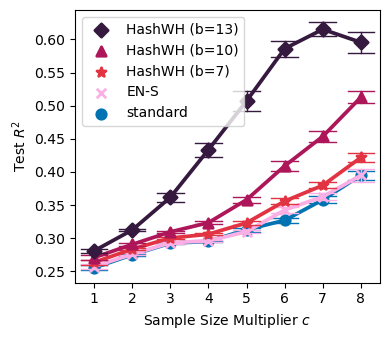

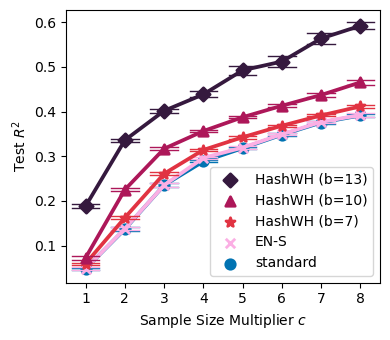

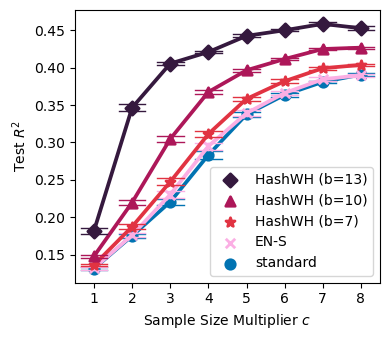

In [24]:

# paper_rc = {'lines.linewidth': 1, 'lines.markersize': 20}                  
# sns.set_context("paper", rc = paper_rc) 

for fix_seed in criteria["fix_seed"]:
    best_results = seeded_best_results[str(fix_seed)]
    runtimes = seeded_runtimes[str(fix_seed)]

    results = {"Training method":[], "Train size": [], "Validation R2": [], "Runtime": []}
    for train_size in criteria["dataset_size_coef"]:
        best_results_train_size = best_results[str(train_size)]
        runtimes_train_size = runtimes[str(train_size)]
        for training_method in best_results_train_size.keys():
            results["Training method"].extend([training_method] * len(best_results_train_size[training_method]))
            results["Train size"].extend([train_size] * len(best_results_train_size[training_method]))
            results["Validation R2"].extend(best_results_train_size[training_method])
            results["Runtime"].extend(runtimes_train_size[training_method])

    fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))

    # R2
    g = sns.pointplot(x="Train size", y="Validation R2", hue="Training method",errorbar='se',
                capsize=.7, data=pd.DataFrame.from_dict(results), errwidth=1, markers=markers)
    ax.set_xlabel("Sample Size Multiplier $c$")
    ax.set_ylabel("Test $R^2$")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[::-1], labels=labels[::-1])

    fig.tight_layout()
    plt.savefig(f'files/synthetic_large/performance_n{criteria["n"]}_seed{fix_seed}.pdf')

point_handle, _ = ax.get_legend_handles_labels()

## Runtime-R2 plot

/tmp/ipykernel_2759/1742982319.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(6, 3), sharey=True, gridspec_kw={'width_ratios': [2.5, 2, 2]})


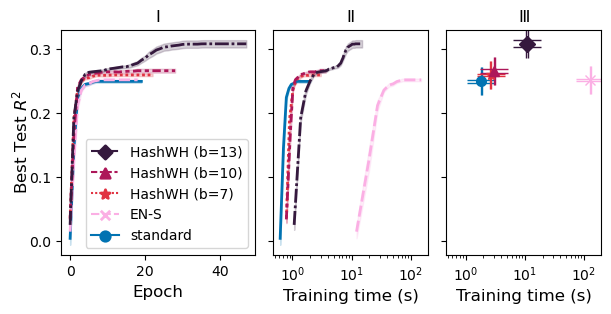

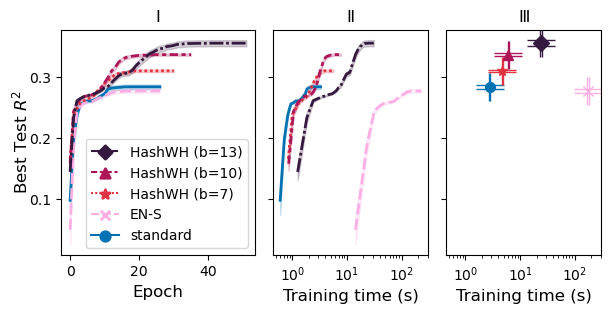

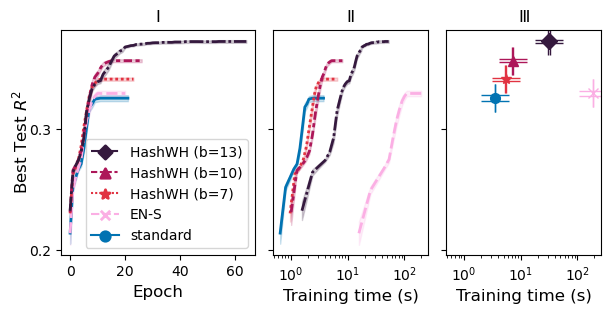

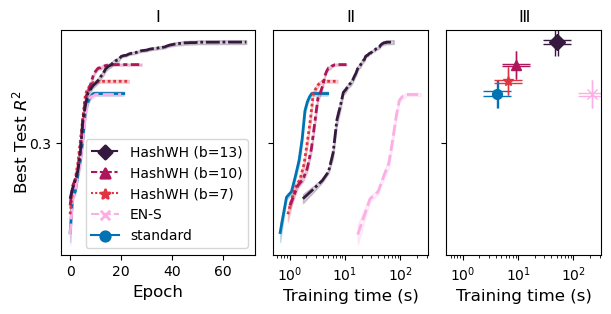

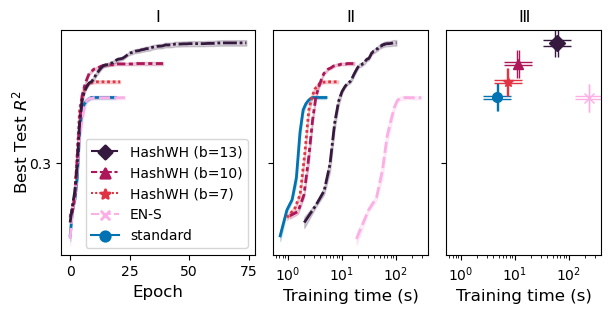

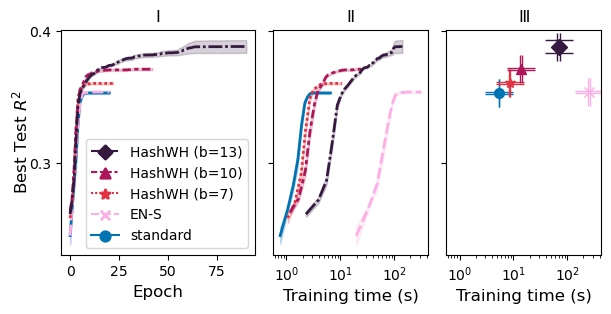

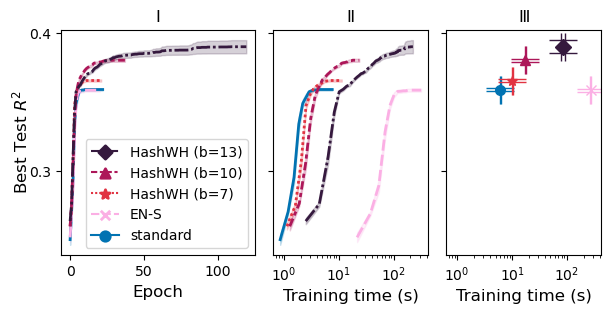

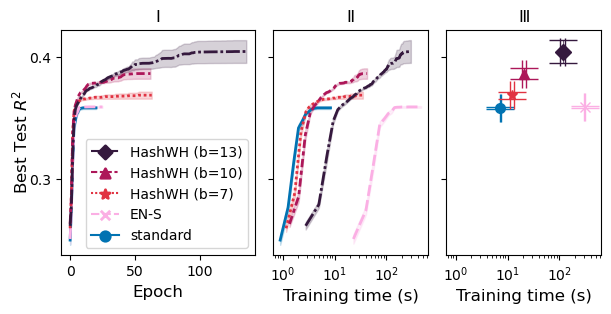

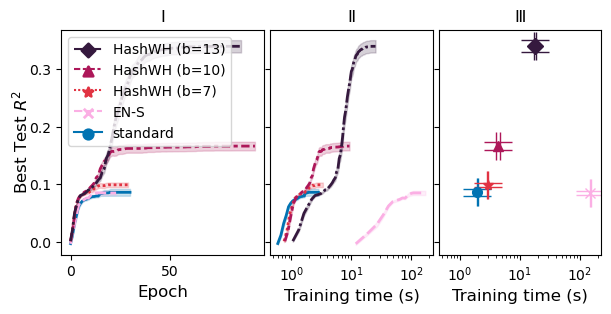

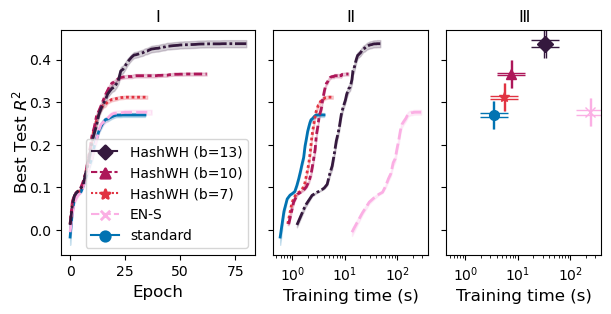

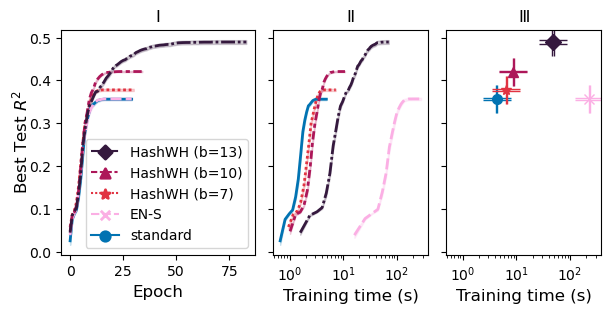

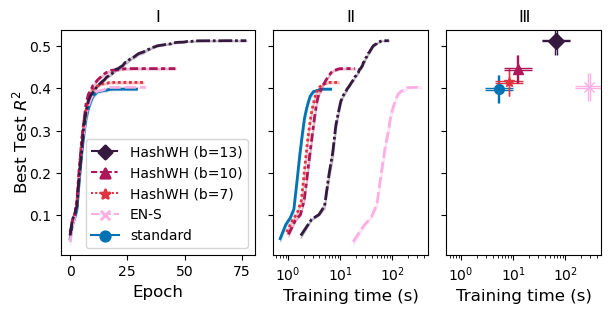

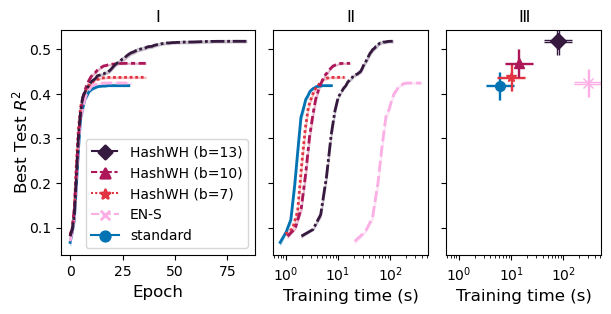

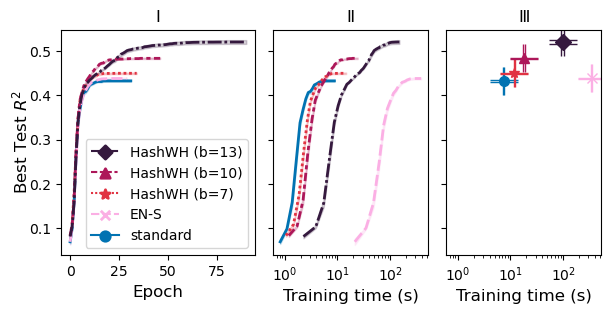

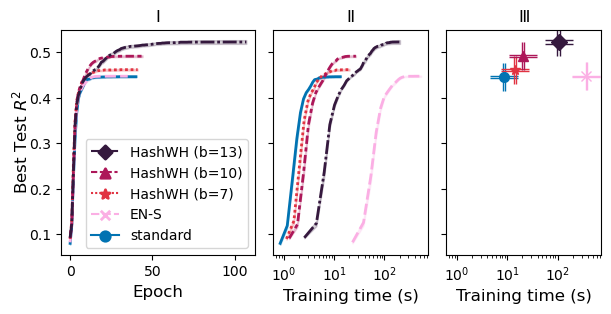

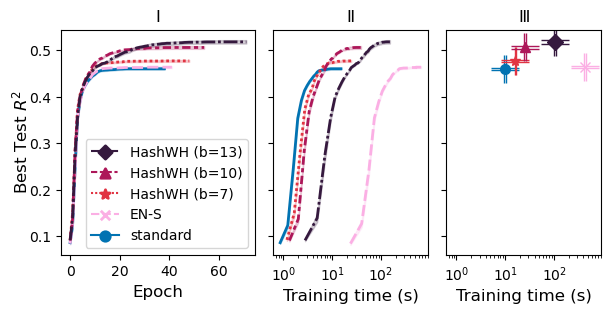

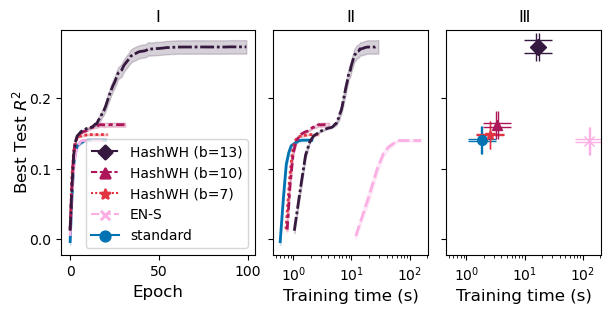

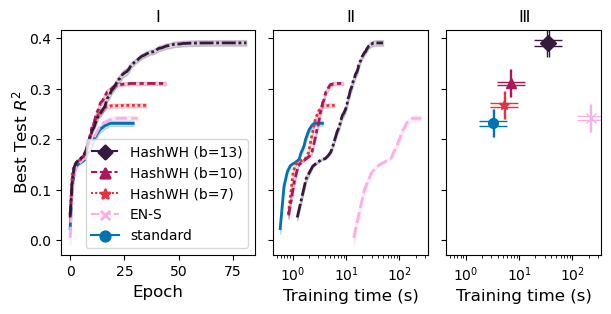

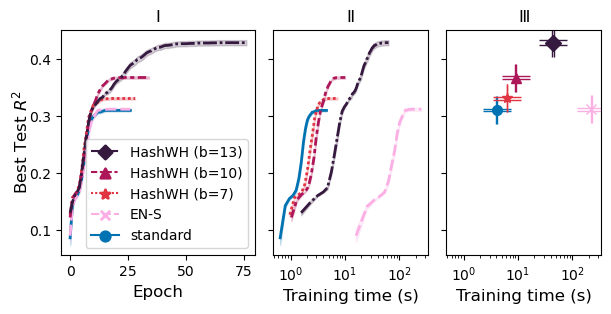

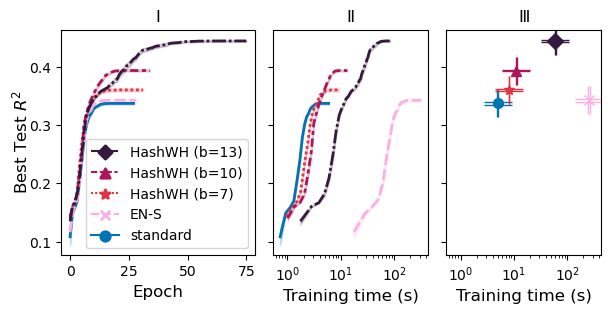

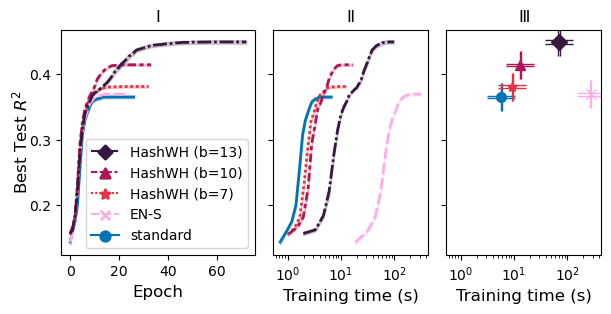

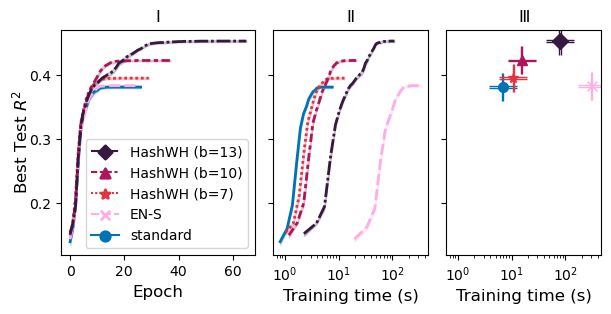

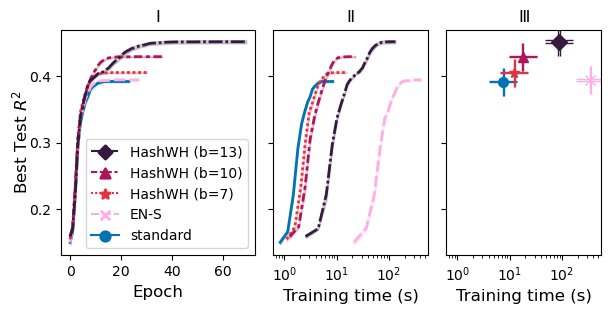

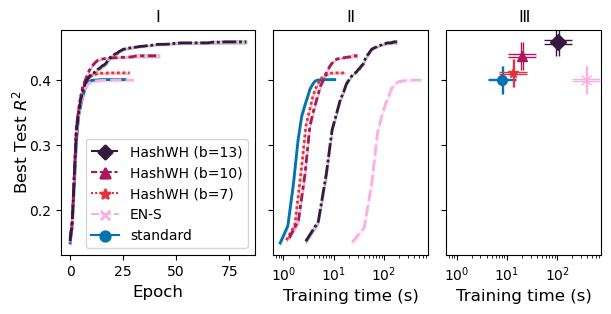

In [31]:
for fix_seed in criteria["fix_seed"]:
    for train_size in criteria["dataset_size_coef"]:
        plot_data = {"Runtime": [], "Test R2": [], "Method": [], "Epoch": []}
        point_data = {"Training method":[], "Time": [], "Time Error": [], "Validation R2": [], "Validation R2 Error": []}

        training_methods = seeded_best_results[str(fix_seed)][str(train_size)].keys()
        for training_method in training_methods:
            epoch_scores = seeded_best_of_epoch_results[str(fix_seed)][str(train_size)][training_method]
            epoch_runtimes = seeded_best_of_epoch_runtimes[str(fix_seed)][str(train_size)][training_method]
            universal_max_epochs = max([len(h) for h in epoch_scores])

            # Extrapolate all runs up to max epochs
            for run in range(len(epoch_runtimes)):
                for epoch in range(len(epoch_scores[run]), universal_max_epochs):
                    epoch_scores[run].append(epoch_scores[run][epoch-1])

            for epoch in range(universal_max_epochs):
                aggregated_runtime = np.mean([h[epoch] for h in epoch_runtimes if len(h)>epoch])
                # aggregated_score = np.mean([h[epoch] for h in epoch_scores if len(h)>epoch])
                aggregated_score = [h[epoch] for h in epoch_scores if len(h)>epoch]

                plot_data["Epoch"].extend([epoch]*len(aggregated_score))
                plot_data["Method"].extend([training_method]*len(aggregated_score))
                plot_data["Runtime"].extend([aggregated_runtime]*len(aggregated_score))
                plot_data["Test R2"].extend(aggregated_score)
            
            # Add point-wise runtimes
            times = seeded_runtimes[str(fix_seed)][str(train_size)][training_method]
            r2s = seeded_best_results[str(fix_seed)][str(train_size)][training_method]
            point_data["Training method"].append(training_method)
            point_data["Time"].append(np.mean(times))
            point_data["Time Error"].append(np.std(times)/np.sqrt(len(times)))
            point_data["Validation R2"].append(np.mean(r2s))
            point_data["Validation R2 Error"].append(np.std(r2s)/np.sqrt(len(r2s)))


        fig, axes = plt.subplots(1, 3, figsize=(6, 3), sharey=True, gridspec_kw={'width_ratios': [2.5, 2, 2]})

        # R2-Epoch
        g1 = sns.lineplot(x="Epoch", y="Test R2", hue="Method", data=pd.DataFrame.from_dict(plot_data), errorbar="se", style="Method" , ax=axes[0], linewidth=2)
        # g1.set_ylabel('Best Test $R^2$')
        g1.set_ylabel(None)
        g1.set_xlabel("Epoch", size="large")
        axes[0].set_yticks(np.arange((min(axes[0].get_yticks()) // 0.1)*0.1, max(axes[0].get_yticks())+0.01, 0.1))
        axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        axes[0].set_title(chr(0x215F + 1))

        # R2-Time
        g2 = sns.lineplot(x="Runtime", y="Test R2", hue="Method", data=pd.DataFrame.from_dict(plot_data), errorbar="se", style="Method", ax=axes[1],legend=False, linewidth=2)
        g2.set_xscale('log')
        g2.set_xlabel('Training time (s)', size="large")
        axes[1].set_title(chr(0x215F + 2))

        # R2-Time (point)
        # g = plt.plot(x="Time", y="Validation R2", hue="Training method", style="Training method", data=pd.DataFrame.from_dict(point_data), legend=False, markers=markers,
        #          linewidth=0, s=100, ax=axes[2])
        # g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
        g3 = axes[2]
        errorbars = []
        for i in range(len(point_data["Time"])):
            marker_size = 7 if i != 4 else 8
            errorbars.append(g3.errorbar(point_data["Time"][i], point_data["Validation R2"][i], xerr=point_data["Time Error"][i], yerr=point_data["Validation R2 Error"][i],
                markersize=marker_size, capsize=10, elinewidth=0.5, ecolor=color_pallete[i], marker=markers[i], color=color_pallete[i]))
        g3.set_xscale('log')
        g3.set_xlabel('Training time (s)', size="large")
        axes[2].set_xlim(axes[1].get_xlim())
        axes[2].set_title(chr(0x215F + 3))

        handles, labels = axes[0].get_legend_handles_labels()
        axes[0].legend(list(zip(handles[::-1], point_handle[::-1])), labels[::-1])

        fig.supylabel("Best Test $R^2$", x=0.01, y=0.55)

        fig.tight_layout(pad=0.2, w_pad=0.1)
        plt.savefig(f'files/synthetic_large/triple_runtime_n{criteria["n"]}_size{train_size}_seed{fix_seed}.pdf')

In [ ]:
for fix_seed in criteria["fix_seed"]:
    for train_size in criteria["dataset_size_coef"]:
        plot_data = {"Runtime": [], "Test R2": [], "Method": [], "Epoch": []}

        training_methods = seeded_best_results[str(fix_seed)][str(train_size)].keys()
        for training_method in training_methods:
            epoch_scores = seeded_best_of_epoch_results[str(fix_seed)][str(train_size)][training_method]
            epoch_runtimes = seeded_best_of_epoch_runtimes[str(fix_seed)][str(train_size)][training_method]
            universal_max_epochs = max([len(h) for h in epoch_scores])

            # Extrapolate all runs up to max epochs
            for run in range(len(epoch_runtimes)):
                for epoch in range(len(epoch_scores[run]), universal_max_epochs):
                    epoch_scores[run].append(epoch_scores[run][epoch-1])

            for epoch in range(universal_max_epochs):
                aggregated_runtime = np.mean([h[epoch] for h in epoch_runtimes if len(h)>epoch])
                # aggregated_score = np.mean([h[epoch] for h in epoch_scores if len(h)>epoch])
                aggregated_score = [h[epoch] for h in epoch_scores if len(h)>epoch]

                plot_data["Epoch"].extend([epoch]*len(aggregated_score))
                plot_data["Method"].extend([training_method]*len(aggregated_score))
                plot_data["Runtime"].extend([aggregated_runtime]*len(aggregated_score))
                plot_data["Test R2"].extend(aggregated_score)

        fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

        # R2-Epoch
        g = sns.lineplot(x="Epoch", y="Test R2", hue="Method", data=pd.DataFrame.from_dict(plot_data), errorbar="se", style="Method", ax=axes[0], linewidth=2)
        handles, labels = axes[0].get_legend_handles_labels()
        axes[0].legend(handles[::-1], labels[::-1])
        g.set_ylabel('Best Test $R^2$')

        # R2-time
        g = sns.lineplot(x="Runtime", y="Test R2", hue="Method", data=pd.DataFrame.from_dict(plot_data), errorbar="se", style="Method", ax=axes[1],legend=False, linewidth=2)
        g.set_xscale('log')
        g.set_xlabel('Training time (s)')
        fig.tight_layout()
        plt.savefig(f'files/synthetic_large/runtime_n{criteria["n"]}_size{train_size}_seed{fix_seed}.pdf')